In [2]:
import numpy as np
import pandas as pd
import pystan
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
from src.stan_data_format import format_stan_data_logistic
from src.utils import pickle_model, load_model, make_latex_table, save_latex_table
from src.clean import clean_exp_2, clean_exp_1
print(pystan.__version__)

%matplotlib inline
%load_ext autoreload
%autoreload 2

2.19.1.1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

<H1>Preprocessing</H1> 


In [9]:
# File locations
EXPERIMENT_1 = './dat/raw/Experiment1.csv'
EXPERIMENT_2 = './dat/raw/Experiment2.csv'

# Output locations
FIGURE_OUTPUT = './out/figures/'
CHAIN_OUTPUT = './out/chains/'
MODEL_OUTPUT = './out/models/'


TABLE_OUTPUT = './out/tables/'
CLEAN_DATA_EXP1 = './dat/cleaned/clean_exp1.csv'
CLEAN_DATA_EXP2 = './dat/cleaned/clean_exp2.csv'

SIMULATION_DATA = './dat/cleaned/simulation.csv'

# Utility function for inv_logit


def ilogit(x):
    return 1/(1+np.exp(-x))

In [10]:
# Clean and save data.
clean_exp1_df = clean_exp_1(pd.read_csv(EXPERIMENT_1))
clean_exp1_df.to_csv(CLEAN_DATA_EXP1)

/home/joseph/github/polarized-collective-wisdom/src/clean.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_data['difficulty'] = [difficulty[item] for item in true_data.states.values]
/home/joseph/github/polarized-collective-wisdom/src/clean.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_data['difficulty'] = [difficulty[item] for item in false_data.states.values]


In [6]:
# Clean and save data.
import os
pd.read_csv('./dat/raw/Experiment2.csv')
clean_exp2_df = clean_exp_2(pd.read_csv(EXPERIMENT_2, skiprows=[1, 2]))
clean_exp2_df.to_csv(CLEAN_DATA_EXP2)

<h2>Extract demographic information for experiments 1, 2</h3>

<ipython-input-7-599431eb30a7>:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(FIGURE_OUTPUT+'Exp1_demographics.pdf', fmt='pdf')
<ipython-input-7-599431eb30a7>:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(FIGURE_OUTPUT+'Exp2_demographics.pdf', fmt='pdf')


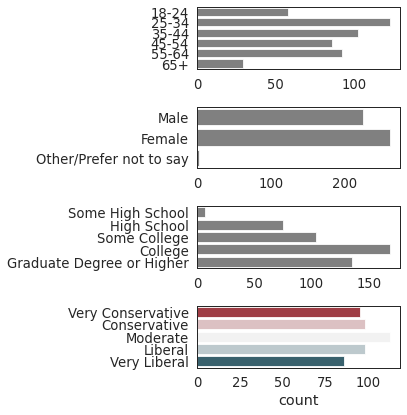

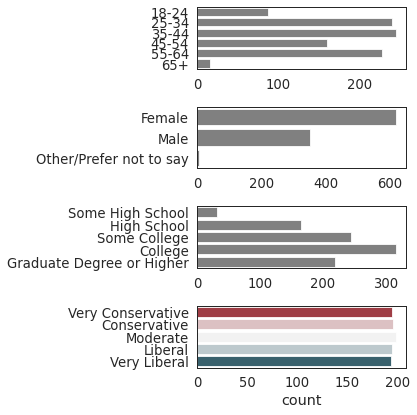

In [7]:
from src.demographics import demographics_exp_1, demographics_exp_2
# Plot demographic figures for SI
plt.figure(figsize=(6, 6))
dem1 = demographics_exp_1(pd.read_csv(EXPERIMENT_1))
plt.savefig(FIGURE_OUTPUT+'Exp1_demographics.pdf', fmt='pdf')
plt.figure(figsize=(6, 6))
dem2 = demographics_exp_2(pd.read_csv(CLEAN_DATA_EXP2))
plt.savefig(FIGURE_OUTPUT+'Exp2_demographics.pdf', fmt='pdf')

<h1>Experiment 1 Analysis</h1>

<h2>Convidence vs. Accuracy</h3> 

In [7]:
model_confidence_accuracy_logit = pystan.StanModel(
    file='./src/confidence_accuracy_logit.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3427a9a7c8850d25368b67c8c12231fc NOW.


<h3>Prior Predictive Check</h3>

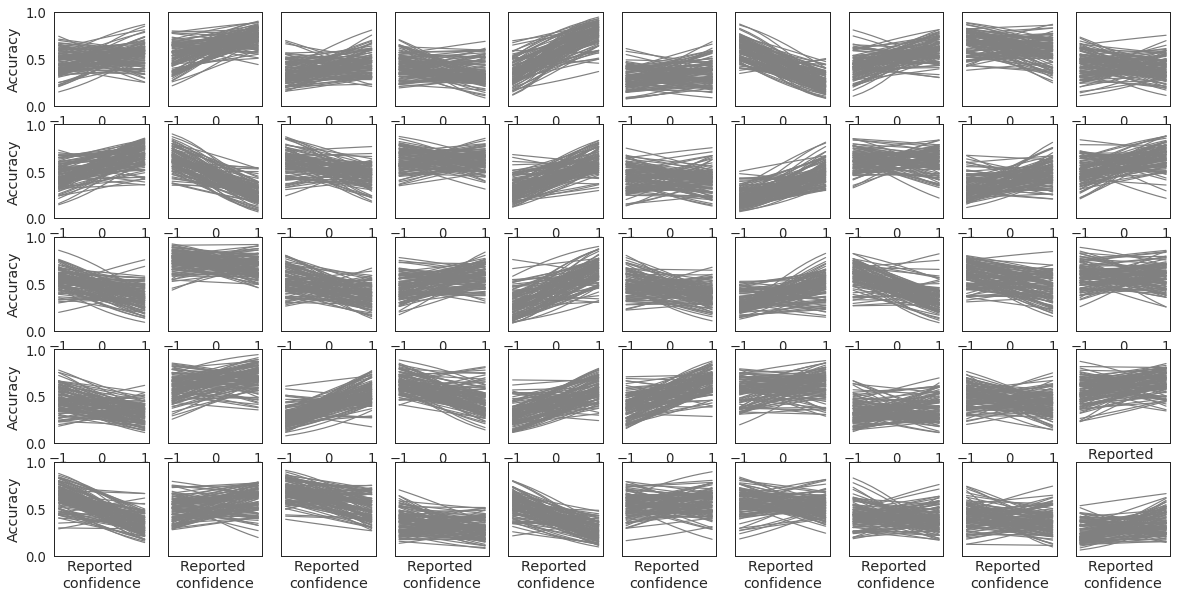

In [8]:
# Get the data in the format the model wants to see it.
stan_data_logistic = format_stan_data_logistic(pd.read_csv(CLEAN_DATA_EXP1))
def plot_figure1b_prior(stan_data_logistic):
    x = np.linspace(np.min(stan_data_logistic['x']),np.max(stan_data_logistic['x']),10)
    plt.figure(figsize=(20, 10))
    for kdx in range(10):
        for idx in range(5):
            plot_no = idx+1 + 5 * kdx
            plt.subplot(5,10,plot_no)
            alpha_p = np.random.normal(0,.4, 1)
            beta_p = np.random.normal(0,.4, 1)
            alpha = np.random.normal(alpha_p, .4, 100)
            beta = np.random.normal(beta_p, .4, 100)
            y = np.array([alpha + beta * item for item in  x])
            y = ilogit(y)
            plt.plot(x,y, color='grey')
            #plt.ylim(.2,.8)
            #plt.xlim(50,100)
            
            if plot_no%10 == 1:
                plt.ylabel('Accuracy')
            else:
                plt.yticks([])
            if plot_no >= 40:
                plt.xlabel('Reported \nconfidence')
                plt.xticks([])
            plt.ylim(0,1)

plot_figure1b_prior(stan_data_logistic)

<h3>Sample and evaluate MCMC</h3>

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
/home/joseph/github/polarized-collective-wisdom/src/utils.py:13: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(samples, output, pickle.HIGHEST_PROTOCOL)
/home/joseph/anaconda3/lib/python3.8/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(
INFO:numba.core.transforms:finding looplift candidates


array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

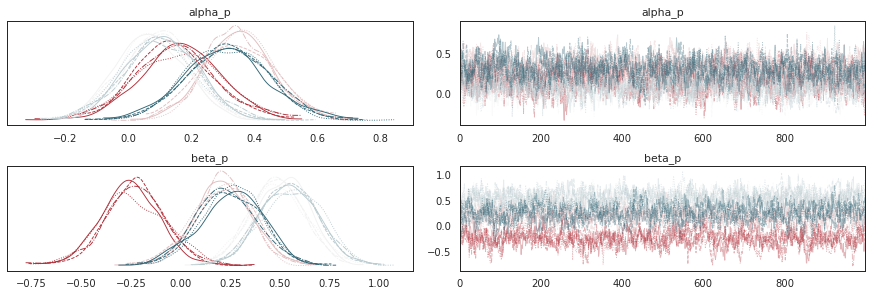

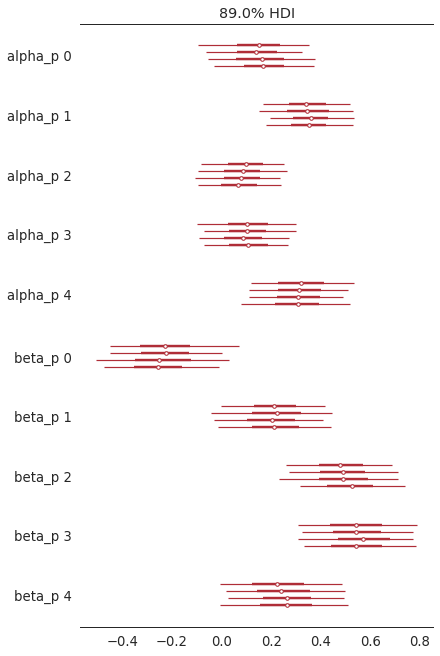

In [12]:
# Get the data in the format the model wants to see it.
stan_data_logistic = format_stan_data_logistic(pd.read_csv(CLEAN_DATA_EXP1))
# MCMC  Time
samples_logistic = model_confidence_accuracy_logit.sampling(
    data=stan_data_logistic)

# Extract samples
extracted_samples_logistic = samples_logistic.extract(['alpha_p', 'beta_p'])
# Save model and output for easy loading later.
pickle_model(model_confidence_accuracy_logit,
             samples_logistic,
             MODEL_OUTPUT,
             CHAIN_OUTPUT,
             'confidence_accuracy_logit')
# Plot chains
#samples_logistic.plot(pars=['alpha_p', 'beta_p'])
az.plot_trace(samples_logistic,
              var_names=['alpha_p', 'beta_p'])
az.plot_forest(samples_logistic, var_names=[
               'alpha_p', 'beta_p'], credible_interval=.89)

In [13]:

model_confidence_accuracy_logit, samples_logistic = load_model(MODEL_OUTPUT,
                                                               CHAIN_OUTPUT,
                                                               'confidence_accuracy_logit')

<h3>Figure and Table output</h3>

In [14]:
# Save key output as a LaTeX file.
variables = ['alpha_p', 'beta_p']
extracted_samples_logistic['beta_p']
latex_string = make_latex_table(extracted_samples_logistic, variables)
print(latex_string)
save_latex_table(TABLE_OUTPUT, 'confidence_accuracy_logit.tex', latex_string)

\begin{tabular}{lrrrrr}
\toprule
variable &      Mean &        sd &      5.5\% &     50.0\% &     94.5\% \\
\midrule
 alpha\_p &  0.155542 &  0.130985 & -0.050077 &  0.155412 &  0.374011 \\
 alpha\_p &  0.352434 &  0.110508 &  0.177792 &  0.349496 &  0.536144 \\
 alpha\_p &  0.082513 &  0.109629 & -0.091768 &  0.083308 &  0.256323 \\
 alpha\_p &  0.100980 &  0.115210 & -0.086609 &  0.099451 &  0.284163 \\
 alpha\_p &  0.312772 &  0.129020 &  0.105955 &  0.311557 &  0.517149 \\
  beta\_p & -0.238404 &  0.157737 & -0.486939 & -0.239725 &  0.013162 \\
  beta\_p &  0.211388 &  0.143653 & -0.025969 &  0.213290 &  0.431916 \\
  beta\_p &  0.494236 &  0.139073 &  0.268959 &  0.494236 &  0.718201 \\
  beta\_p &  0.551768 &  0.146765 &  0.320962 &  0.550998 &  0.787179 \\
  beta\_p &  0.248280 &  0.155634 & -0.004252 &  0.249366 &  0.492080 \\
\bottomrule
\end{tabular}



In [15]:
from src.exp_1_figures import plot_figure1a
exp_1_data = pd.read_csv(CLEAN_DATA_EXP1)
plt.savefig(FIGURE_OUTPUT+'joint_hpdi.pdf', fmt='pdf')

<ipython-input-15-5a5c1ba4c955>:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(FIGURE_OUTPUT+'joint_hpdi.pdf', fmt='pdf')


<Figure size 432x288 with 0 Axes>

/home/joseph/github/polarized-collective-wisdom/src/exp_1_figures.py:49: UserWarning: linewidths is ignored by contourf
  CS = plt.contourf(xi, yi, zi,levels = levels,
/home/joseph/github/polarized-collective-wisdom/src/exp_1_figures.py:49: UserWarning: The following kwargs were not used by contour: 'shade'
  CS = plt.contourf(xi, yi, zi,levels = levels,


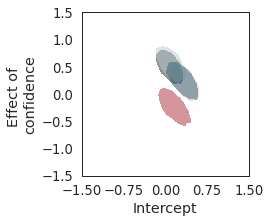

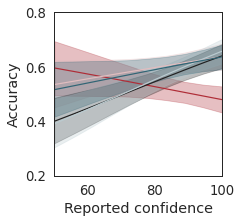

In [16]:
from src.exp_1_figures import joint_hpdi

plt.figure(figsize=(3,3))
sns.set_context('paper', font_scale=1.5)
joint_hpdi(extracted_samples_logistic)


from src.exp_1_figures import plot_figure1b

plt.figure(figsize=(3,3))
sns.set_context('paper', font_scale=1.5)
plot_figure1b(extracted_samples_logistic, stan_data_logistic)



<h3>Accuracy by Political Leaning</h3>

/home/joseph/anaconda3/lib/python3.8/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(
INFO:numba.core.transforms:finding looplift candidates


array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

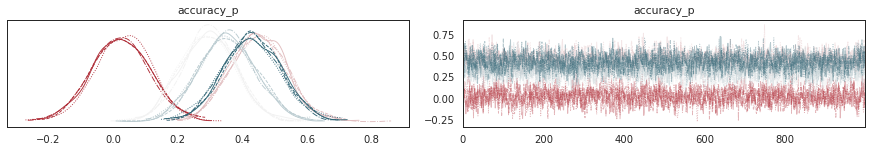

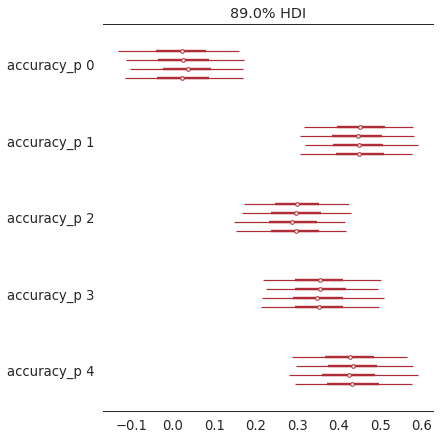

In [17]:
az.plot_trace(samples_logistic, var_names=['accuracy_p'])
az.plot_forest(samples_logistic, var_names=['accuracy_p'],
               credible_interval=.89)

In [18]:
extracted_samples_logistic = samples_logistic.extract(['accuracy_p'])
variables = ['accuracy_p']
extracted_samples_logistic['accuracy_p'] = ilogit(extracted_samples_logistic['accuracy_p'])
latex_string = make_latex_table(extracted_samples_logistic, variables)
print(latex_string)
save_latex_table(TABLE_OUTPUT, 'accuracy.tex', latex_string)


\begin{tabular}{lrrrrr}
\toprule
   variable &      Mean &        sd &      5.5\% &     50.0\% &     94.5\% \\
\midrule
 accuracy\_p &  0.506526 &  0.022320 &  0.470422 &  0.506380 &  0.541972 \\
 accuracy\_p &  0.610140 &  0.020636 &  0.577488 &  0.610297 &  0.642770 \\
 accuracy\_p &  0.573072 &  0.020462 &  0.540944 &  0.573333 &  0.605384 \\
 accuracy\_p &  0.587301 &  0.021514 &  0.552722 &  0.587194 &  0.621817 \\
 accuracy\_p &  0.605460 &  0.021459 &  0.570873 &  0.605460 &  0.640178 \\
\bottomrule
\end{tabular}



<h2>Agent model of confidence</h2>

<h3>Prior Predictitive Checks</h3>

/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


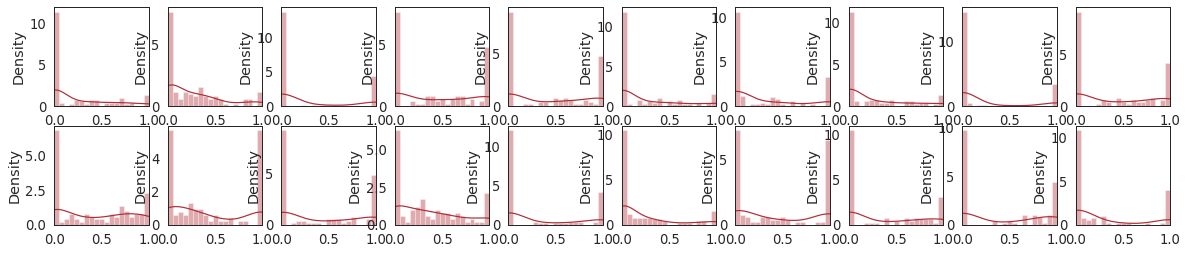

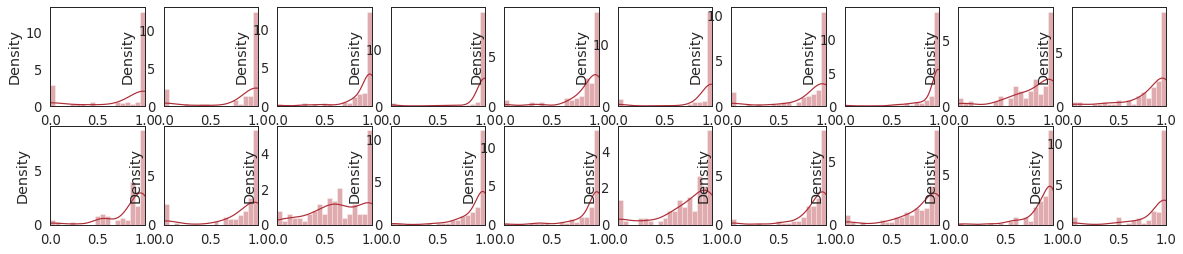

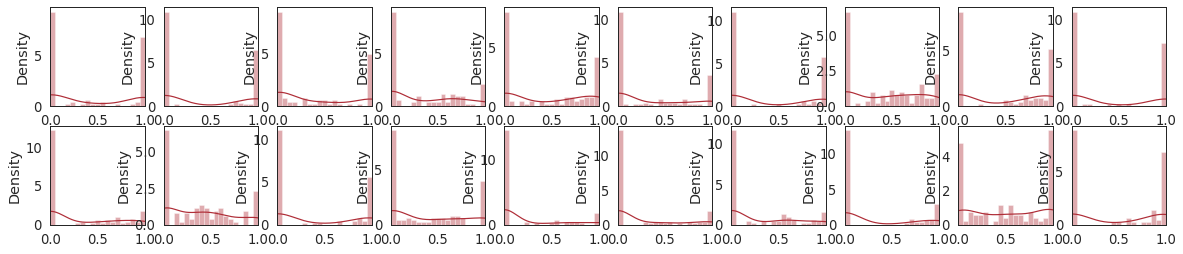

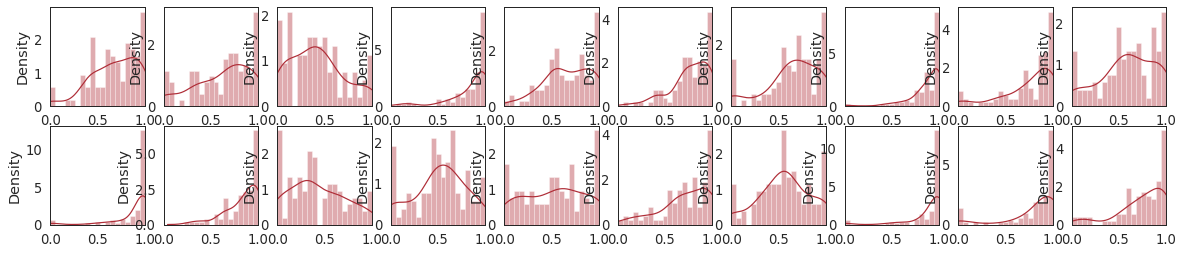

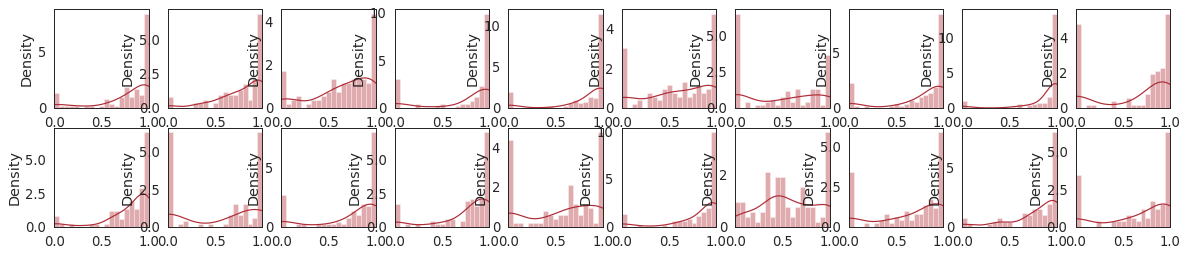

In [19]:
#Simulate different political groups
correct = 1 #Change to zero to simulate when incorrect

for p in range(5):
    plt.figure(figsize=(20,4))
    mu_a_pol  = np.random.normal(0,1)
    alpha_a_pol =  np.random.normal(-1,1)
    gamma_a_pol =  np.random.normal(0,1)

    mu_b_pol  =  np.random.normal(0,.5)
    alpha_b_pol =  np.random.normal(0,.5)
    gamma_b_pol =  np.random.normal(0,.5)
    #And Individuals
    for k in range(20):



        mu_a = np.random.normal(mu_a_pol,.5)
        alpha_a = np.random.normal(alpha_a_pol,.5)
        gamma_a = np.random.normal(gamma_a_pol,.5)

        mu_b  = np.random.normal(mu_b_pol,.5)
        alpha_b = np.random.normal(alpha_b_pol,.5)
        gamma_b = np.random.normal(gamma_b_pol,.5)


        mu = np.zeros(100)
        alpha = np.zeros(100)
        gamma = np.zeros(100)
        y_sim = np.zeros(100)


        plt.subplot(2,10,k+1)
        for i in range(100):
            theta = abs(np.random.normal(0,5));
            mu[i] = ilogit(mu_a + mu_b*correct);
            alpha[i] = ilogit(alpha_a + alpha_b*correct);
            gamma[i] = ilogit(gamma_a + gamma_b*correct);

            if np.random.binomial(1, alpha[i])==1:
                if np.random.binomial(1, gamma[i]) == 1:
                    y_sim[i] = 1
                else:
                    y_sim[i] = 0
            else: 
                y_sim[i] = np.random.beta(mu[i]*theta, (1-mu[i])*theta)

        sns.distplot(y_sim,bins=np.linspace(0,1,20))
        plt.xlim(0,1)
    

<h3>Model compiliation and Sampling</h3>


In [20]:
belief_model = pystan.StanModel(file='./src/belief_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5e5b3cb09920a7f1c37ee7574bf7946a NOW.


In [21]:
exp_1_data =  pd.read_csv(CLEAN_DATA_EXP1)
from src.stan_data_format import format_stan_data_belief
stan_data = format_stan_data_belief(exp_1_data)
belief_samples = belief_model.sampling(data = stan_data)


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [22]:
pickle_model(belief_model, 
             belief_samples, 
             MODEL_OUTPUT, 
             CHAIN_OUTPUT, 
             'belief')

/home/joseph/github/polarized-collective-wisdom/src/utils.py:13: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(samples, output, pickle.HIGHEST_PROTOCOL)


<h3>Evaluate MCMC</h3>

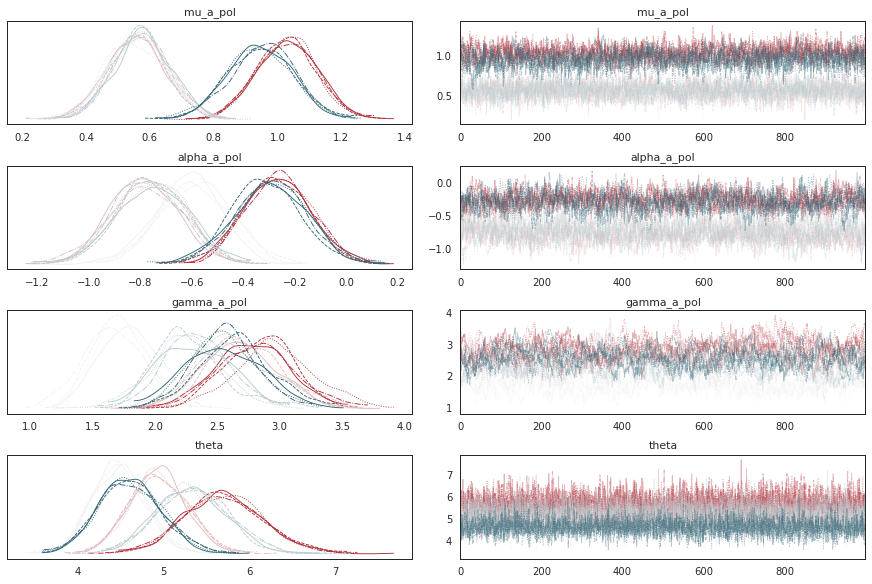

In [23]:
az.plot_trace(belief_samples, 
              var_names=['mu_a_pol', 
                         'alpha_a_pol',
                         'gamma_a_pol',
                        'theta']);

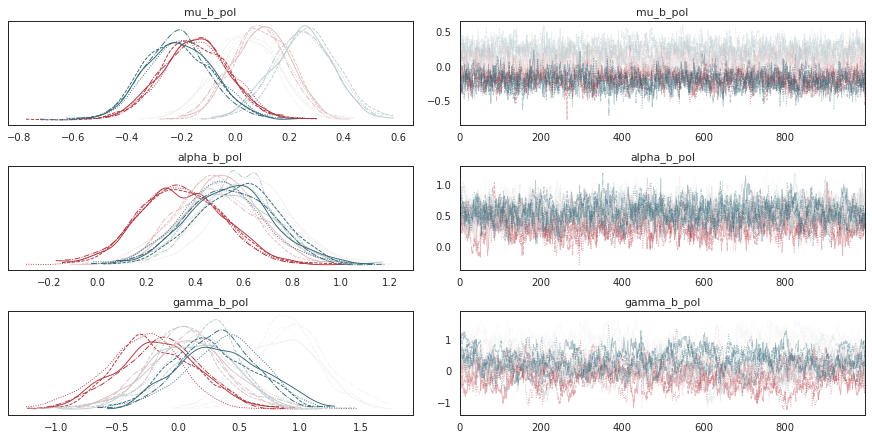

In [24]:
az.plot_trace(belief_samples, 
              var_names=['mu_b_pol', 
                         'alpha_b_pol',
                         'gamma_b_pol']);

In [25]:
extracted_belief_samples = belief_samples.extract(['mu_b_pol', 
                         'alpha_b_pol',
                         'gamma_b_pol','mu_a_pol', 
                         'alpha_a_pol',
                         'gamma_a_pol','theta'])
variables = ['alpha_a_pol', 'gamma_a_pol', 'mu_a_pol', 
             'alpha_b_pol', 'gamma_b_pol', 'mu_b_pol','theta' ]
# extracted_samples_logistic['accuracy_p'] = ilogit(extracted_samples_logistic['accuracy_p'])
latex_string = make_latex_table(extracted_belief_samples, variables)
print(latex_string)
save_latex_table(TABLE_OUTPUT, 'confidence_agent.tex', latex_string)


\begin{tabular}{lrrrrr}
\toprule
    variable &      Mean &        sd &      5.5\% &     50.0\% &     94.5\% \\
\midrule
 alpha\_a\_pol & -0.266965 &  0.127271 & -0.467965 & -0.267008 & -0.064690 \\
 alpha\_a\_pol & -0.771869 &  0.135978 & -0.990699 & -0.770555 & -0.562703 \\
 alpha\_a\_pol & -0.593683 &  0.134030 & -0.809727 & -0.593034 & -0.382716 \\
 alpha\_a\_pol & -0.762800 &  0.135208 & -0.977168 & -0.764182 & -0.548012 \\
 alpha\_a\_pol & -0.294766 &  0.138577 & -0.517077 & -0.296832 & -0.073551 \\
 gamma\_a\_pol &  2.844304 &  0.312597 &  2.347879 &  2.850356 &  3.359459 \\
 gamma\_a\_pol &  2.662762 &  0.311586 &  2.193439 &  2.640499 &  3.191258 \\
 gamma\_a\_pol &  1.725662 &  0.233590 &  1.366370 &  1.719559 &  2.113274 \\
 gamma\_a\_pol &  2.294279 &  0.287138 &  1.857882 &  2.282400 &  2.770997 \\
 gamma\_a\_pol &  2.575988 &  0.285947 &  2.122760 &  2.568327 &  3.050785 \\
    mu\_a\_pol &  1.029115 &  0.093503 &  0.877613 &  1.030136 &  1.176113 \\
    mu\_a\_pol &  0.5

<h3>Posterior Predictive</h3>

In [26]:
#Some of those chains look a bit autocorrelated but converged, so let's look at the ppd. 

belief_model, belief_samples = load_model(MODEL_OUTPUT,
                                           CHAIN_OUTPUT, 
                                        'belief')

belief_samps = belief_samples.extract()


/home/joseph/github/polarized-collective-wisdom/src/posterior_predictive.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_data['yhat'] = belief_samps['yhat'][-1,:]
/home/joseph/github/polarized-collective-wisdom/src/posterior_predictive.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_data['mean_yhat'] = np.mean(false_data['yhat'],axis=0)
<ipython-input-27-1d7a6d463db4>:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3

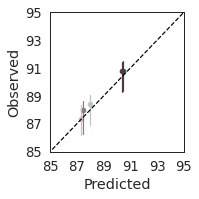

In [27]:
from src.posterior_predictive import plot_predicted_vs_observed_belief_model
#plt.savefig('../Graphs/PredictedVsObserved.pdf', fmt='.pdf',dpi=1500)
exp_1_data =  pd.read_csv(CLEAN_DATA_EXP1)

sns.set_context('paper',font_scale=1.5)
plt.figure(figsize=(3,3))
plot_predicted_vs_observed_belief_model(belief_samps, exp_1_data);
plt.tight_layout()
plt.savefig(FIGURE_OUTPUT+'PredctedVsObservedBelief.pdf', fmt='pdf')


/home/joseph/github/polarized-collective-wisdom/src/posterior_predictive.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_data['yhat'] = belief_samps['yhat'][-1,:]
/home/joseph/github/polarized-collective-wisdom/src/posterior_predictive.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_data['mean_yhat'] = np.mean(false_data['yhat'],axis=0)
<ipython-input-28-fa42905c8b3c>:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3

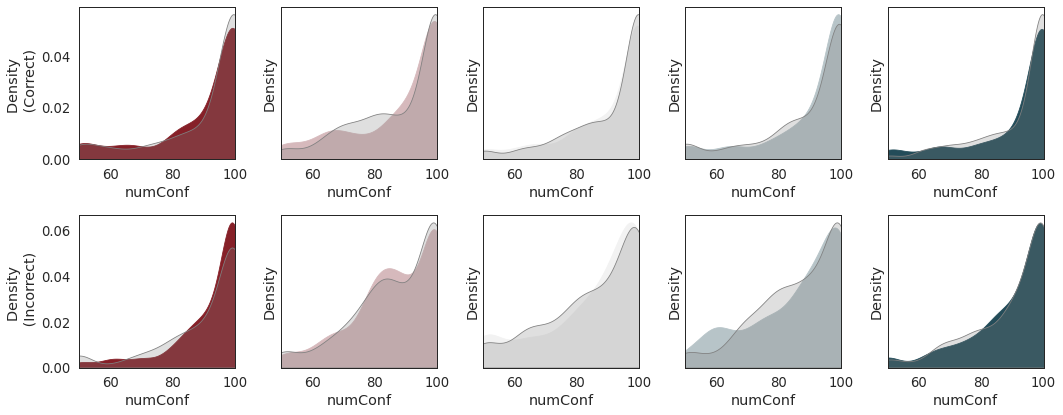

In [28]:
from src.posterior_predictive import plot_belief_model_distributions

exp_1_data =  pd.read_csv(CLEAN_DATA_EXP1)
sns.set_context()
plt.figure(figsize=(15,6))
plot_belief_model_distributions(exp_1_data,belief_samps)
plt.savefig(FIGURE_OUTPUT+'PosteriorPredictiveConfidenceDistributions.pdf', fmt='pdf')



<h2>Agent model of social influence</h2>

<h3>Model for Initially Correct Participants</h3>

<h4>Compile and Sample</h4>

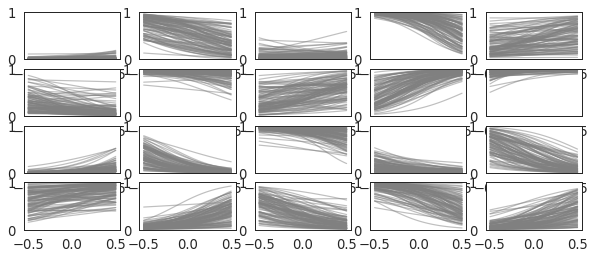

In [29]:
plt.figure(figsize=(10, 4))
for idx in range(20):
    plt.subplot(4,5,idx+1)
    alpha_p = np.random.normal(0,2);
    b_conf_p = np.random.normal(0,2);
    b_socConf_p = np.random.normal(0,2);

    alpha = np.random.normal(alpha_p, 1, 100);
    b_conf = np.random.normal(b_conf_p, 1, 100);

    x = np.linspace(-.5,.5, 100)
    y_sim = np.array([alpha + b_conf * item for item in x])
    plt.plot(x,ilogit(y_sim),color='grey',alpha=.5)
    plt.ylim(0,1)

In [30]:
switch_model = pystan.StanModel(file='./src/switch_model.stan')


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_68dd4818b050fd456b35236fb514ed4e NOW.


In [31]:
from src.stan_data_format import format_stan_data_switch
exp_1_data =  pd.read_csv(CLEAN_DATA_EXP1)


stan_model_data_correct, _= format_stan_data_switch(exp_1_data,correct=True)

switch_samples_correct = switch_model.sampling(data=stan_model_data_correct)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


<h4>Evaluate MCMC</h4>

/home/joseph/github/polarized-collective-wisdom/src/utils.py:13: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(samples, output, pickle.HIGHEST_PROTOCOL)


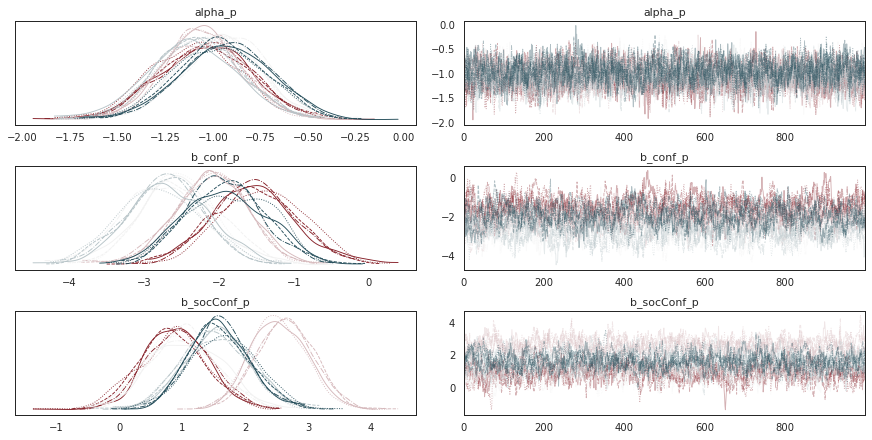

In [32]:
import arviz as av
#Extract samples
extracted_switch_samples_correct = switch_samples_correct.extract(['alpha_p', 
                                            'b_conf_p', 
                                            'b_socConf_p'])


#Save model and output for easy loading later. 
pickle_model(switch_model, 
             switch_samples_correct, 
             MODEL_OUTPUT, 
             CHAIN_OUTPUT, 
             'switch_samples_correct');

#Plot chains
av.plot_trace(switch_samples_correct, var_names=['alpha_p', 
                                        'b_conf_p', 
                                            'b_socConf_p']);

<h4>Plot and Table</h4>

Text(0.5, 1.0, 'Initially \ncorrect')

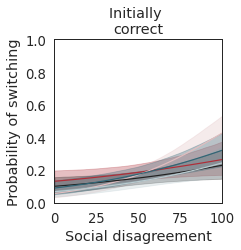

In [33]:
from src.exp_1_figures import plot_fig1cd

stan_model_data_correct, df= format_stan_data_switch(exp_1_data,correct=True)

sns.set_context('paper', font_scale=1.5)
plt.figure(figsize=(3,3))
plot_fig1cd(stan_model_data_correct, df, extracted_switch_samples_correct)

plt.title('Initially \ncorrect')




In [34]:
#Make table 
variables = ['alpha_p','b_conf_p','b_socConf_p']
latex_string = make_latex_table(extracted_switch_samples_correct, variables)
print(latex_string)
save_latex_table(TABLE_OUTPUT, 'extracted_switch_samples_correct.tex', latex_string)


\begin{tabular}{lrrrrr}
\toprule
    variable &      Mean &        sd &      5.5\% &     50.0\% &     94.5\% \\
\midrule
     alpha\_p & -1.056880 &  0.243637 & -1.440203 & -1.051426 & -0.675604 \\
     alpha\_p & -1.056555 &  0.208180 & -1.382240 & -1.057253 & -0.725204 \\
     alpha\_p & -0.966151 &  0.217892 & -1.318248 & -0.959858 & -0.627579 \\
     alpha\_p & -1.088859 &  0.226364 & -1.450211 & -1.088496 & -0.723309 \\
     alpha\_p & -0.947433 &  0.236279 & -1.321249 & -0.947339 & -0.571093 \\
    b\_conf\_p & -1.506457 &  0.559429 & -2.392278 & -1.514037 & -0.597006 \\
    b\_conf\_p & -2.090057 &  0.478612 & -2.873206 & -2.082064 & -1.357591 \\
    b\_conf\_p & -2.595094 &  0.533018 & -3.435595 & -2.601965 & -1.721281 \\
    b\_conf\_p & -2.729334 &  0.526985 & -3.583519 & -2.726992 & -1.882569 \\
    b\_conf\_p & -1.907784 &  0.536130 & -2.759340 & -1.921622 & -1.058317 \\
 b\_socConf\_p &  0.885118 &  0.525261 &  0.049107 &  0.886437 &  1.730324 \\
 b\_socConf\_p &  2.578646

<h3>Model for Initially Incorrect particpants</h3>

<h4>Compile and Sample</h4>

In [35]:
from src.stan_data_format import format_stan_data_switch
exp_1_data =  pd.read_csv(CLEAN_DATA_EXP1)


stan_model_data_incorrect, df = format_stan_data_switch(exp_1_data,correct=False)

switch_samples_incorrect = switch_model.sampling(data=stan_model_data_incorrect)



To run all diagnostics call pystan.check_hmc_diagnostics(fit)


<h4> Evaluate MCMC </h4>

/home/joseph/github/polarized-collective-wisdom/src/utils.py:13: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(samples, output, pickle.HIGHEST_PROTOCOL)


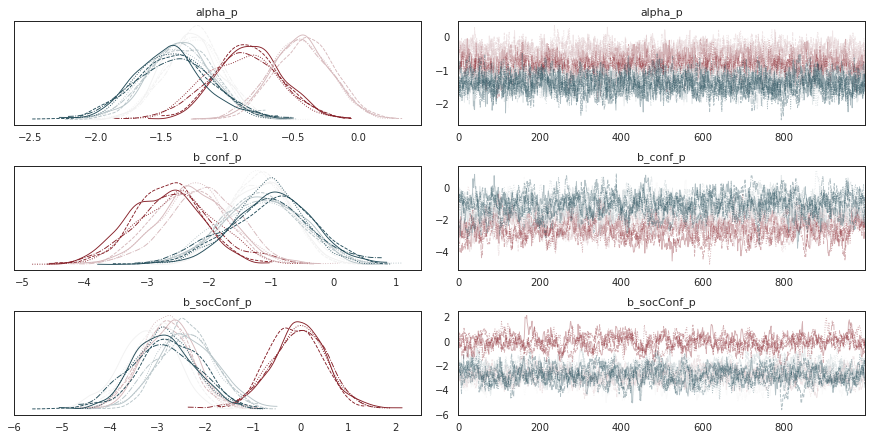

In [36]:
import arviz as av
#Extract samples
extracted_switch_samples_incorrect = switch_samples_incorrect.extract(['alpha_p', 
                                            'b_conf_p', 
                                            'b_socConf_p'])


#Save model and output for easy loading later. 
pickle_model(switch_model, 
             switch_samples_incorrect, 
             MODEL_OUTPUT, 
             CHAIN_OUTPUT, 
             'switch_samples_incorrect');
#Plot chains
av.plot_trace(switch_samples_incorrect, var_names=['alpha_p', 
                                        'b_conf_p', 
                                            'b_socConf_p']);

<h4>Plot and Table</h4>

Text(0.5, 1.0, 'Initially \nincorrect')

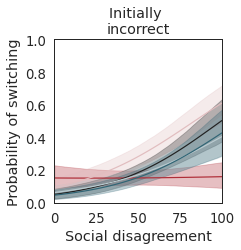

In [37]:
from src.exp_1_figures import plot_fig1cd

stan_model_data_incorrect, df= format_stan_data_switch(exp_1_data,correct=False)

sns.set_context('paper', font_scale=1.5)
plt.figure(figsize=(3,3))
plot_fig1cd(stan_model_data_incorrect, df, extracted_switch_samples_incorrect, correct=False)
plt.title('Initially \nincorrect')




In [38]:
#Make table
from src.utils import make_latex_table
variables = ['alpha_p','b_conf_p','b_socConf_p']
latex_string = make_latex_table(extracted_switch_samples_incorrect, variables)
print(latex_string)
save_latex_table(TABLE_OUTPUT, 'extracted_switch_samples_incorrect.tex', latex_string)


\begin{tabular}{lrrrrr}
\toprule
    variable &      Mean &        sd &      5.5\% &     50.0\% &     94.5\% \\
\midrule
     alpha\_p & -0.860112 &  0.266816 & -1.283508 & -0.859104 & -0.431191 \\
     alpha\_p & -0.436471 &  0.229855 & -0.805553 & -0.435579 & -0.070883 \\
     alpha\_p & -1.264189 &  0.221688 & -1.616244 & -1.261072 & -0.914501 \\
     alpha\_p & -1.358588 &  0.248622 & -1.750800 & -1.361697 & -0.966503 \\
     alpha\_p & -1.415023 &  0.283204 & -1.860864 & -1.415287 & -0.958437 \\
    b\_conf\_p & -2.601139 &  0.618805 & -3.571468 & -2.595097 & -1.587430 \\
    b\_conf\_p & -2.222842 &  0.593422 & -3.189968 & -2.218834 & -1.291822 \\
    b\_conf\_p & -1.178405 &  0.494090 & -1.958033 & -1.176439 & -0.393838 \\
    b\_conf\_p & -1.164089 &  0.646002 & -2.216903 & -1.161856 & -0.136821 \\
    b\_conf\_p & -1.037570 &  0.658142 & -2.137726 & -1.009742 & -0.007041 \\
 b\_socConf\_p & -0.053588 &  0.585631 & -0.995270 & -0.044984 &  0.850850 \\
 b\_socConf\_p & -2.799610

<h3> Posterior Preditive Checks</h3>

<ipython-input-39-eaa9840926ff>:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(FIGURE_OUTPUT+'PredctedVsObservedSwitch.pdf', fmt='pdf')


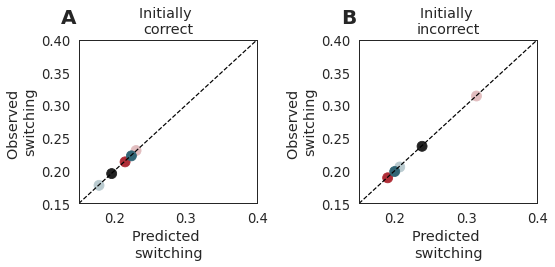

In [39]:
from src.exp_1_figures import plot_switch_predicted_acuracy
plt.figure(figsize=(8,4))
plt.subplot(121)
stan_model_data_incorrect, df= format_stan_data_switch(exp_1_data,correct=True)
plot_switch_predicted_acuracy(df, switch_samples_correct, correct=True)
plt.title('Initially \ncorrect')
ax=plt.gca()

ax.text(-0.1, 1.1, 'A', transform=ax.transAxes, 
        size=20, weight='bold')
plt.subplot(122)
stan_model_data_incorrect, df= format_stan_data_switch(exp_1_data,correct=False)
plot_switch_predicted_acuracy(df, switch_samples_incorrect, correct=False)
plt.title('Initially \nincorrect')
ax=plt.gca()

ax.text(-0.1, 1.1, 'B', transform=ax.transAxes, 
        size=20, weight='bold')
plt.tight_layout()
plt.savefig(FIGURE_OUTPUT+'PredctedVsObservedSwitch.pdf', fmt='pdf')


<h2>Figure 1</h2>

/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


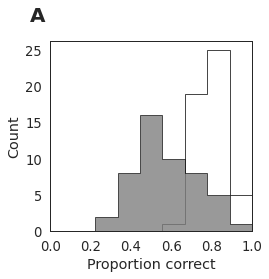

In [155]:
from src.exp_1_figures import plot_figure1a
from src.exp_1_figures import plot_figure1b

sns.set_context('paper', font_scale=1.5)

plt.figure(figsize=(7,7))
plt.subplot(221)
exp_1_data = pd.read_csv(CLEAN_DATA_EXP1)
plot_figure1a(exp_1_data[exp_1_data
                         .answer==True],exp_1_data[exp_1_data.answer==False])
ax=plt.gca()
ax.text(-0.1, 1.1, 'A', transform=ax.transAxes, 
        size=20, weight='bold')
plt.tight_layout()

/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-156-ce92de9144e0>:52: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(FIGURE_OUTPUT+'Figure1.pdf', fmt='pdf')


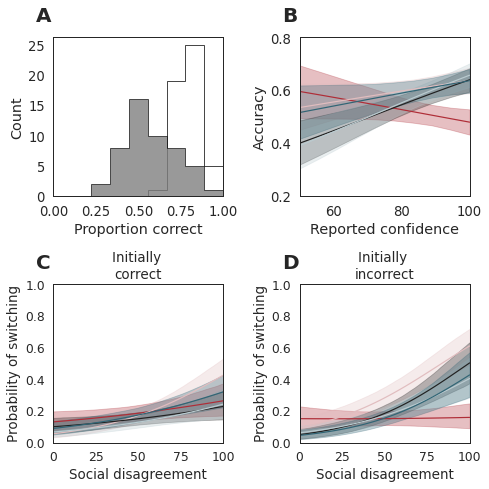

In [156]:
from src.exp_1_figures import plot_figure1a
from src.exp_1_figures import plot_figure1b

sns.set_context('paper', font_scale=1.5)

plt.figure(figsize=(7,7))
plt.subplot(221)
exp_1_data = pd.read_csv(CLEAN_DATA_EXP1)
plot_figure1a(exp_1_data[exp_1_data
                         .answer==True],exp_1_data[exp_1_data.answer==False])
ax=plt.gca()
ax.text(-0.1, 1.1, 'A', transform=ax.transAxes, 
        size=20, weight='bold')
plt.tight_layout()


plt.subplot(222)
sns.set_context('paper', font_scale=1.4)
model_confidence_accuracy_logit, samples_logistic = load_model(MODEL_OUTPUT,
                                                               CHAIN_OUTPUT, 
                                                            'confidence_accuracy_logit')
#Extract samples
extracted_samples_logistic = samples_logistic.extract(['alpha_p', 'beta_p'])
#Get the data in the format the model wants to see it. 
stan_data_logistic = format_stan_data_logistic(pd.read_csv(CLEAN_DATA_EXP1))
plot_figure1b(extracted_samples_logistic, stan_data_logistic)
ax=plt.gca()
ax.text(-0.1, 1.1, 'B', transform=ax.transAxes, 
        size=20, weight='bold')
plt.tight_layout()

plt.subplot(223)
exp_1_data =  pd.read_csv(CLEAN_DATA_EXP1)
stan_model_data_incorrect, df = format_stan_data_switch(exp_1_data,correct=True)
plot_fig1cd(stan_model_data_correct, df, extracted_switch_samples_correct)
plt.title('Initially \ncorrect')
ax=plt.gca()
ax.text(-0.1, 1.1, 'C', transform=ax.transAxes, 
        size=20, weight='bold')
plt.tight_layout()

plt.subplot(224)
exp_1_data =  pd.read_csv(CLEAN_DATA_EXP1)
stan_model_data_incorrect, df = format_stan_data_switch(exp_1_data,correct=False)
plot_fig1cd(stan_model_data_incorrect, df, extracted_switch_samples_incorrect,correct=False)
plt.title('Initially \nincorrect')
ax=plt.gca()
ax.text(-0.1, 1.1, 'D', transform=ax.transAxes, 
        size=20, weight='bold')
plt.tight_layout()

plt.savefig(FIGURE_OUTPUT+'Figure1.pdf', fmt='pdf')


<h1> Simulation Study</h1>

<h2>Load Models</h2>

In [102]:
switch_samples_correct_model, switch_samples_correct = load_model(MODEL_OUTPUT,
                                                                  CHAIN_OUTPUT,
                                                                  'switch_samples_correct')
extracted_switch_samples_correct = switch_samples_correct.extract(['alpha_p',
                                                                   'b_conf_p',
                                                                   'b_socConf_p'])


switch_samples_incorrect_model, switch_samples_incorrect = load_model(MODEL_OUTPUT,
                                                                      CHAIN_OUTPUT,
                                                                      'switch_samples_incorrect')
extracted_switch_samples_incorrect = switch_samples_incorrect.extract(['alpha_p',
                                                                       'b_conf_p',
                                                                       'b_socConf_p'])


belief_model, belief_samples = load_model(MODEL_OUTPUT,
                                          CHAIN_OUTPUT,
                                          'belief')

extracted_belief_samples = belief_samples.extract()

<h2>Simulate</h2>

In [103]:
from pandarallel import pandarallel
import itertools as it
from src.simulation_study import run_single
from tqdm.auto import tqdm
from multiprocessing import cpu_count

tqdm.pandas(desc="my bar!")

pandarallel.initialize(nb_workers=cpu_count(), progress_bar=True)


dat_dict ={'proportions':[[75,50,30,50,75]],
             'p':[.5,.75,.98],
             'diff':np.linspace(.40,.6,20),
             'repeat':np.arange(2000),
             'N':[500],
             'lean':np.array(['right','left',False])}

def get_combinations_dataframe(dd):
    allNames = sorted(dd)
    combinations = it.product(*(dd[Name] for Name in allNames))
    dat = pd.DataFrame(list(combinations), columns=allNames)
    return(dat)

df = get_combinations_dataframe(dat_dict)
    
run_row = lambda dat : run_single(dat['p'],
            dat['diff'],
            dat['N'],
            dat['proportions'],
            dat['lean'],
            extracted_belief_samples,
            extracted_switch_samples_incorrect,
            extracted_switch_samples_correct)

%time simulation_results = df.parallel_apply(run_row, axis=1)



/home/joseph/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


CPU times: user 1min 19s, sys: 7.67 s, total: 1min 26s
Wall time: 6min 20s


<h3>Store Data</h3>

In [104]:
# df['correct_final'] = np.array(np.hstack(simulation_results))
sim_results = np.vstack(simulation_results)
df['correct_final'] = sim_results[:,0]
df['correct_start'] = sim_results[:,0]
df.to_csv(SIMULATION_DATA)



<h3>Load Data</h3>

In [105]:
simulation_results = pd.read_csv(SIMULATION_DATA)
simulation_results['total'] = np.ones(simulation_results.shape[0])
simulation_results['correct_majority'] = simulation_results['correct_final'] > .5
simulation_results.head()
simulation_results.shape

(360000, 11)

<h3>Plot Results</h3>

In [106]:
from scipy import stats
def get_bionomial_ci(n=100,k=200,res=1000,q = [5.5, 94.5]):
    p_grid = np.linspace(0,1,res)
    likelihood = stats.binom(k, p_grid).pmf(n)
    prior = np.ones(res)
    posterior=likelihood*prior
    posterior = posterior/np.sum(posterior)

    samples = np.random.choice(p_grid, p=posterior,size=res)
    return(np.percentile(samples, q=q))



def plot_simulation_results(temp,N=500): 
    grouped =  temp.groupby(['p', 'lean','diff']).sum().reset_index()
    grouped.head()
    #plt.scatter(grouped['diff'], grouped['correct_majority'])
    samples_per_difficulty = grouped['total'].values[0]

    ci = np.array([get_bionomial_ci(n=item,k=samples_per_difficulty) for item in grouped['correct_majority'].values])
    pal = sns.color_palette("Greens", n_colors=5)
    grouped['lower'] = ci[:,0]
    grouped['upper'] = ci[:,1]
    ps = [.5,.75,.98]
    for idx in range(3):
        temp = grouped[grouped.p==ps[idx]]
        t1 = temp.groupby(['diff']).mean().reset_index()
        plt.plot(t1['diff'].values, 
                 t1['correct_majority'].values/samples_per_difficulty, 
                 color=pal[idx+2])

        plt.fill_between(t1['diff'].values, t1['lower'], t1['upper'],color=pal[idx+2],alpha=.3)
        head_length = .05
    plt.plot(t1['diff'].values, 
             1-stats.binom(N,t1['diff'].values).cdf(N/2),
             ls='--', 
             color='grey',lw=2)
    plt.ylabel('Collective Accuracy') 
    plt.xlabel('Initial proportion correct')

def add_arrow(dat):

    temp1 = dat[dat.p==.98]
    t1 = temp1.groupby(['diff']).mean().reset_index()
    temp2 = dat[dat.p==.5]
    t2 = temp2.groupby(['diff']).mean().reset_index()
    samples_per_difficulty = t2['total'].values[0]

    diff = t1['correct_majority']/samples_per_difficulty - t2['correct_majority']/samples_per_difficulty

    maxdiff = np.argmax(np.abs(diff))
    print(t2['diff'][maxdiff])
    ax = plt.gca()
    print(t1.shape)


    head_length = .05
    ax.arrow(t2['diff'][maxdiff],
             t2['correct_majority'][maxdiff]/samples_per_difficulty, 
             0,
             t1['correct_majority'][maxdiff]/samples_per_difficulty- \
             t2['correct_majority'][maxdiff]/samples_per_difficulty + \
             head_length,
            head_width=0.015, head_length=head_length, fc='grey', ec='grey')



0.5157894736842106
(20, 9)


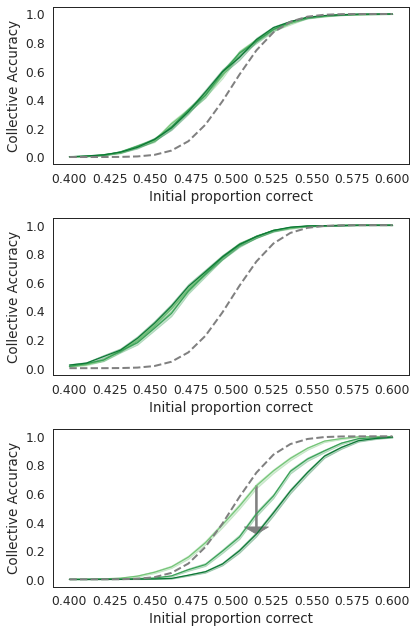

In [107]:
plt.figure(figsize=(6,9))
plt.subplot(311)
fig = plot_simulation_results(simulation_results[simulation_results.lean=='False'])
plt.tight_layout()
plt.subplot(312)
fig = plot_simulation_results(simulation_results[simulation_results.lean=='left'])
plt.tight_layout()
plt.subplot(313)
fig = plot_simulation_results(simulation_results[simulation_results.lean=='right'])
add_arrow(simulation_results[simulation_results.lean=='right'])
plt.tight_layout()



<h1>Experiment 2</h1>

<h2>Model compilation and sampling</h2>

<h3>Prior Predictive Simulation</h3>

/home/joseph/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

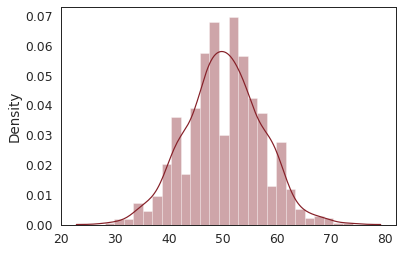

<Figure size 432x288 with 0 Axes>

In [108]:

alpha = np.random.normal(0,.2,1000);

y = np.random.binomial(100, ilogit(alpha));
sns.distplot(y)
plt.figure()


In [109]:

def format_stan_data_exp2(exp_2_data):
    false_exp2_data = exp_2_data[exp_2_data.answer==False]
    false_exp2_data['count'] = np.ones(false_exp2_data.shape[0])
    N = false_exp2_data.shape[0]
    p = 1*(false_exp2_data.p_recode.values)
    cond = false_exp2_data['cond_recode'].values+1
    y = 1*(false_exp2_data['social_correct'].values)
    false_exp2_data['cond_recode']
    pd.Categorical(false_exp2_data['cond_recode'])
    grouped_exp2 = false_exp2_data.groupby(['state', 'cond_recode', 'p_recode']).sum().reset_index()
    
    
    state_data = dict(y=grouped_exp2['social_correct'].astype('int').values,
                        N = grouped_exp2.shape[0],
                        count=grouped_exp2['count'].astype('int').values,
                        cond = grouped_exp2['p_recode'].values *3 + \
                           grouped_exp2['cond_recode'].astype('int').values+1)
    return state_data, false_exp2_data
stan_data_exp2, exp2_data = format_stan_data_exp2(pd.read_csv(CLEAN_DATA_EXP2))

print(stan_data_exp2)
  

{'y': array([61, 45, 43, 53, 53, 50, 38, 42, 48, 35, 50, 40, 31, 51, 42, 53, 44,
       42, 54, 50, 40, 37, 52, 41, 48, 65, 49, 48, 40, 43, 49, 35, 36, 58,
       34, 46, 34, 47, 51, 45, 56, 43, 36, 56, 50, 60, 38, 37, 49, 58, 58,
       45, 50, 44, 40, 40, 46, 44, 56, 40]), 'N': 60, 'count': array([ 88,  82,  81,  80,  91,  86,  78,  74,  95,  86,  85,  77,  60,
        85,  84,  92,  74,  89,  88,  87,  81,  85,  84,  94,  78,  90,
        81,  85,  71,  74,  83,  68,  70,  80,  69,  85,  63,  98,  80,
        85,  83,  75,  68,  89,  86, 100,  71,  75,  83,  85,  90,  87,
        81,  72,  84,  80,  85,  84,  82,  75]), 'cond': array([1, 4, 2, 5, 3, 6, 1, 4, 2, 5, 3, 6, 1, 4, 2, 5, 3, 6, 1, 4, 2, 5,
       3, 6, 1, 4, 2, 5, 3, 6, 1, 4, 2, 5, 3, 6, 1, 4, 2, 5, 3, 6, 1, 4,
       2, 5, 3, 6, 1, 4, 2, 5, 3, 6, 1, 4, 2, 5, 3, 6])}


<ipython-input-109-f461c30dc08a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_exp2_data['count'] = np.ones(false_exp2_data.shape[0])


In [110]:
#from src.stan_data_format import format_stan_data_exp2
stan_data_exp2, exp2_data = format_stan_data_exp2(pd.read_csv(CLEAN_DATA_EXP2))
exp2_model = pystan.StanModel(file='./src/experiment_2_validation.stan')


<ipython-input-109-f461c30dc08a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_exp2_data['count'] = np.ones(false_exp2_data.shape[0])
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1440b0a435e2ad1856dabafc7c770426 NOW.


In [111]:
exp2_samples = exp2_model.sampling(data=stan_data_exp2)

<h2>Evaluate MCMC</h2

In [112]:
exp2_samples

Inference for Stan model: anon_model_1440b0a435e2ad1856dabafc7c770426.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]   0.25  1.0e-3   0.07   0.11    0.2   0.25   0.29   0.38   4375    1.0
alpha[2]    0.2  9.6e-4   0.06   0.07   0.16    0.2   0.24   0.33   4574    1.0
alpha[3]   0.35  9.8e-4   0.07   0.21    0.3   0.35    0.4   0.49   4976    1.0
alpha[4]    0.3  9.2e-4   0.06   0.18   0.26    0.3   0.35   0.43   4958    1.0
alpha[5]   0.19  1.0e-3   0.07   0.06   0.15   0.19   0.24   0.32   4130    1.0
alpha[6]   0.11  1.0e-3   0.07  -0.02   0.06   0.11   0.16   0.24   4103    1.0
lp__      -3359    0.04   1.71  -3363  -3360  -3358  -3357  -3356   2234    1.0

Samples were drawn using NUTS at Sat Jan 30 12:47:03 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reductio

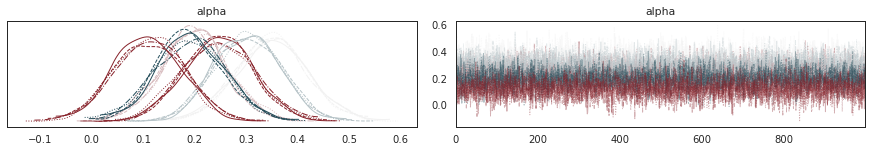

In [113]:
az.plot_trace(exp2_samples);

-0.058833940512114824
[-0.09596215 -0.02088964]


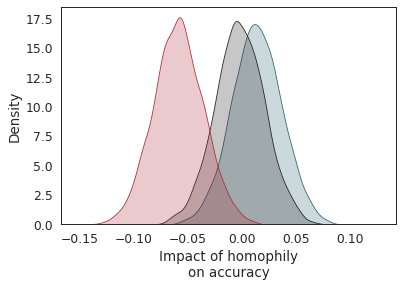

In [114]:
extracted_exp2 = exp2_samples.extract()


def plot_fig2F(exp2_samples):

    pal = sns.diverging_palette(10, 220, sep=80, n=3,l=40,center='light')
    pal2 = sns.diverging_palette(10, 220, sep=80, n=3,l=40,center='dark')
    pal[1] = pal2[1]

    pal_order = [2,1,0]


    for idx in range(3):
        sns.kdeplot(ilogit(extracted_exp2['alpha'][:,3+idx])-ilogit(extracted_exp2['alpha'][:,idx]),
                    shade=True, 
                    color=pal[pal_order[idx]])

    print(np.mean(ilogit(extracted_exp2['alpha'][:,3+idx])-ilogit(extracted_exp2['alpha'][:,idx])))
    print(np.percentile(ilogit(extracted_exp2['alpha'][:,3+idx])-ilogit(extracted_exp2['alpha'][:,idx]), q=[5.5,94.5]))

    plt.xlabel('Impact of homophily\non accuracy')
    plt.ylabel('Density')

plot_fig2F(extracted_exp2)

<h2>Coefficient Table</h2>

In [115]:
variables = ['logit_alpha']
extracted_exp2['logit_alpha'] = ilogit(extracted_exp2['alpha'])
latex_string = make_latex_table(extracted_exp2, variables)
print(latex_string)
save_latex_table(TABLE_OUTPUT, 'experiment2.tex', latex_string)


\begin{tabular}{lrrrrr}
\toprule
    variable &      Mean &        sd &      5.5\% &     50.0\% &     94.5\% \\
\midrule
 logit\_alpha &  0.561238 &  0.016879 &  0.533953 &  0.561337 &  0.588535 \\
 logit\_alpha &  0.549500 &  0.016001 &  0.522941 &  0.549728 &  0.575401 \\
 logit\_alpha &  0.586573 &  0.016744 &  0.559808 &  0.586825 &  0.613431 \\
 logit\_alpha &  0.574985 &  0.015728 &  0.549922 &  0.575076 &  0.599858 \\
 logit\_alpha &  0.547584 &  0.016477 &  0.521217 &  0.547296 &  0.573794 \\
 logit\_alpha &  0.527739 &  0.016649 &  0.501319 &  0.527805 &  0.554129 \\
\bottomrule
\end{tabular}



<h1>Figure 2</h1>

In [117]:


#plot_fig2E(exp2_data, exp2_samples)


In [118]:
from PIL import Image

def make_square(im, min_size=1000, fill_color=(0, 0, 0, 0)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGBA', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im



In [119]:
simulation_results = pd.read_csv(SIMULATION_DATA)
simulation_results['total'] = np.ones(simulation_results.shape[0])
simulation_results['correct_majority'] = simulation_results['correct_final'] > .5
simulation_results.head()

,Unnamed: 0,N,diff,lean,p,proportions,repeat,correct_final,correct_start,total,correct_majority
0,0,500,0.4,right,0.5,"[75, 50, 30, 50, 75]",0,0.438,0.438,1.0,False
1,1,500,0.4,right,0.5,"[75, 50, 30, 50, 75]",1,0.404,0.404,1.0,False
2,2,500,0.4,right,0.5,"[75, 50, 30, 50, 75]",2,0.444,0.444,1.0,False
3,3,500,0.4,right,0.5,"[75, 50, 30, 50, 75]",3,0.444,0.444,1.0,False
4,4,500,0.4,right,0.5,"[75, 50, 30, 50, 75]",4,0.454,0.454,1.0,False


0.5157894736842106
(20, 9)
0.586573223074372


<ipython-input-109-f461c30dc08a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_exp2_data['count'] = np.ones(false_exp2_data.shape[0])
<ipython-input-120-a85e41f771df>:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(FIGURE_OUTPUT+'Figure2.pdf',dpi=1500, fmt='pdf')


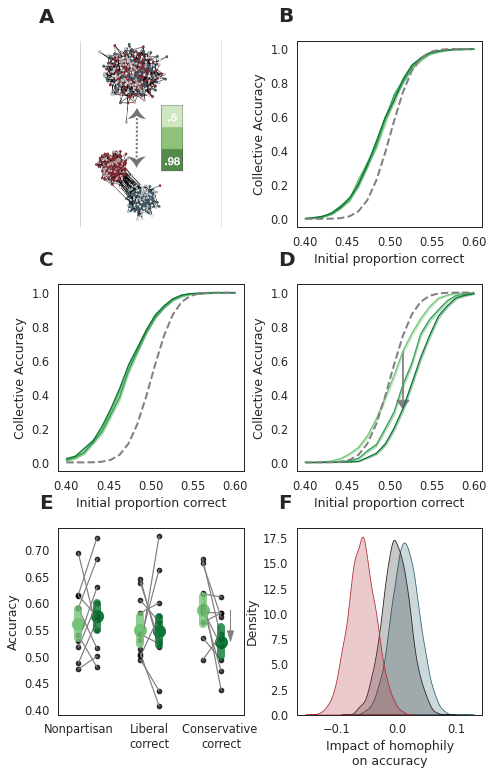

In [120]:
from src.exp_2_figures import plot_fig2E, plot_fig2F

sns.set_context('paper', font_scale=1.3)
plt.subplots(3,2,figsize=(7,10.5))


plt.subplot(322)
fig = plot_simulation_results(simulation_results[simulation_results.lean=='False'])
ax = plt.gca()
ax.text(-0.1, 1.1, 'B', transform=ax.transAxes, 
        size=20, weight='bold')


plt.subplot(321)
test_image = Image.open('./art/figure2A.png')
new_image = make_square(test_image)
plt.imshow(new_image)


ax = plt.gca()

ax.axis('off')
ax.text(-0.1, 1.1, 'A', transform=ax.transAxes, 
        size=20, weight='bold')

plt.tight_layout()
plt.subplot(323)
ax = plt.gca()

ax.text(-0.1, 1.1, 'C', transform=ax.transAxes, 
        size=20, weight='bold')
fig = plot_simulation_results(simulation_results[simulation_results.lean=='left'])

plt.tight_layout()
plt.subplot(324)
ax = plt.gca()

ax.text(-0.1, 1.1, 'D', transform=ax.transAxes, 
        size=20, weight='bold')
fig = plot_simulation_results(simulation_results[simulation_results.lean=='right'])
add_arrow(simulation_results[simulation_results.lean=='right'])



plt.subplot(3,2,5)
ax = plt.gca()
ax.text(-0.1, 1.1, 'E', transform=ax.transAxes, 
        size=20, weight='bold')
stan_data_exp2, exp2_data = format_stan_data_exp2(pd.read_csv(CLEAN_DATA_EXP2))
plot_fig2E(exp2_data, exp2_samples)


plt.subplot(3,2,6)
ax = plt.gca()
ax.text(-0.1, 1.1, 'F', transform=ax.transAxes, 
        size=20, weight='bold')
plot_fig2F(exp2_samples)
plt.savefig(FIGURE_OUTPUT+'Figure2.pdf',dpi=1500, fmt='pdf')

<h1>Conceptual model</h1>

<h2>Define model and estimate parametrs from data</h3>

In [133]:

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

<ipython-input-146-d96b41d72935>:47: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(FIGURE_OUTPUT+'Figure3.pdf',dpi=1500, fmt='pdf')


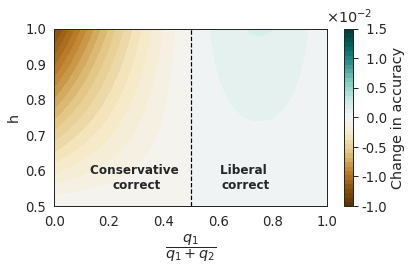

In [146]:
def get_prob(q1, q2, p, a11, g11, a22, g22, a21, g21, a12, g12):
    bb = p*(q1*(1-q1)*(a11-g11)) + (1-p) * (q2*a21*(1-q1)-g21*q1*(1-q2))

    cc = p*(q2*(1-q2)*(a22-g22)) + (1-p) * (q1*a12*(1-q2)-g12*q2*(1-q1))
    return (q1+q2+bb+cc)/2


#1=Libera
a11 = .25
g11 = .2
a12 = .2
g12 = .2

#2=Conservative
a22 = .2
g22 = .2
a21 = .25
g21 = .2



p = np.linspace(0.5, 1.0, 500)
q = np.linspace(0,1,500)

X, Y = np.meshgrid(q, p)
sns.set_context('paper', font_scale=1.5)
sns.set_palette(sns.diverging_palette(100, 280, s=85, l=25, n=20))

Z = get_prob(X, (1-X), Y, a11, g11, a22, g22, a21, g21, a12, g12) - \
    get_prob(X, (1-X), .5, a11, g11, a22, g22, a21, g21, a12, g12) 
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z*100,levels=np.linspace(-1.5, 1.5, 41),cmap=plt.get_cmap('BrBG'))
cb = fig.colorbar(cp,ticks=[-1.5,-1,-.5,0,.5,1.0,1.5]) # Add a colorbar to a plot
cb.ax.set_title(r'$\times 10^{-2}$')

cb.set_label('Change in accuracy')
cb.ax.set_yticklabels(['-1.0','-1.0','-0.5',' 0.0',' 0.5', ' 1.0', ' 1.5']) 
ax.set_xlabel('$\dfrac{q_1}{q_1+q_2}$')
ax.set_ylabel('h')
plt.plot([.5,.5], [.5,1], ls='--', color='k')
plt.tight_layout()

ax.text(0.3, .1, 'Conservative \ncorrect', transform=ax.transAxes, 
        size=12, weight='bold',horizontalalignment='center')
ax.text(0.7, .1, 'Liberal \ncorrect', transform=ax.transAxes, 
        size=12, weight='bold',horizontalalignment='center')
plt.savefig(FIGURE_OUTPUT+'Figure3.pdf',dpi=1500, fmt='pdf')